<a href="https://colab.research.google.com/github/cherukRahul/final-project-AIR-QUALITY-FORECASTING-/blob/main/Rahul_final_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1️⃣ Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

#  Load Dataset
file_path = "city_day.csv"
df = pd.read_csv(file_path)

#  Basic Info
print("✅ Data Loaded Successfully!")
print(f"Shape: {df.shape}")
print("\nColumns:", df.columns.tolist())
df.head()

#  Data Summary
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nUnique Cities:", df['City'].nunique())

#  Convert Dates and Sort
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by=['City', 'Date']).reset_index(drop=True)

#  Handle Missing Values (Forward Fill by City)
df = df.groupby('City').apply(lambda x: x.fillna(method='ffill')).reset_index(drop=True)

✅ Data Loaded Successfully!
Shape: (29531, 16)

Columns: ['City', 'Date', 'PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene', 'AQI', 'AQI_Bucket']

Missing Values per Column:
 City              0
Date              0
PM2.5          4598
PM10          11140
NO             3582
NO2            3585
NOx            4185
NH3           10328
CO             2059
SO2            3854
O3             4022
Benzene        5623
Toluene        8041
Xylene        18109
AQI            4681
AQI_Bucket     4681
dtype: int64

Unique Cities: 26


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Step 3: Exploratory Data Analysis (EDA)

# 3.1 Overview of the Dataset
print(df.info())
print(df.describe())

# 3.2 Missing Values Check
print(df.isnull().sum())

# Print the first few columns (say, first 3 columns) for the first few rows
print(df.iloc[:, :].head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   City        29531 non-null  object        
 1   Date        29531 non-null  datetime64[ns]
 2   PM2.5       27109 non-null  float64       
 3   PM10        20050 non-null  float64       
 4   NO          28352 non-null  float64       
 5   NO2         28351 non-null  float64       
 6   NOx         27968 non-null  float64       
 7   NH3         21139 non-null  float64       
 8   CO          29525 non-null  float64       
 9   SO2         28399 non-null  float64       
 10  O3          28269 non-null  float64       
 11  Benzene     26385 non-null  float64       
 12  Toluene     25100 non-null  float64       
 13  Xylene      14491 non-null  float64       
 14  AQI         27690 non-null  float64       
 15  AQI_Bucket  27690 non-null  object        
dtypes: datetime64[ns](1), 

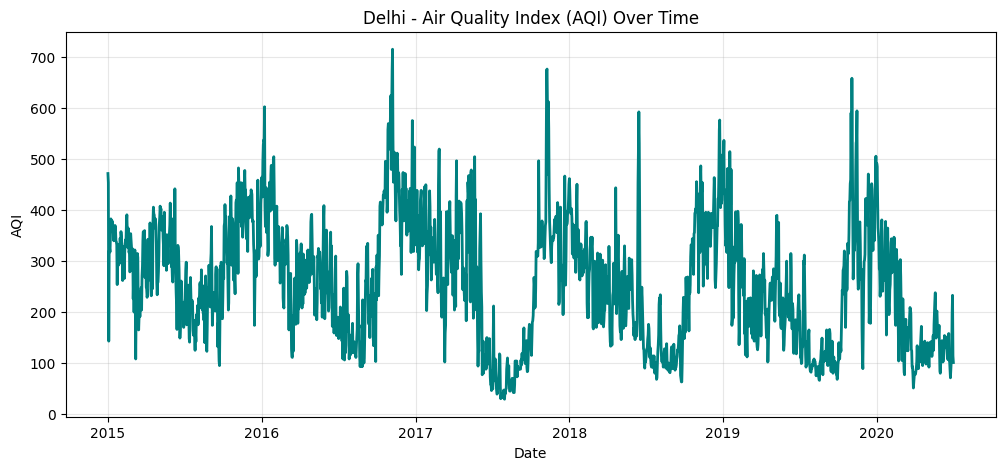

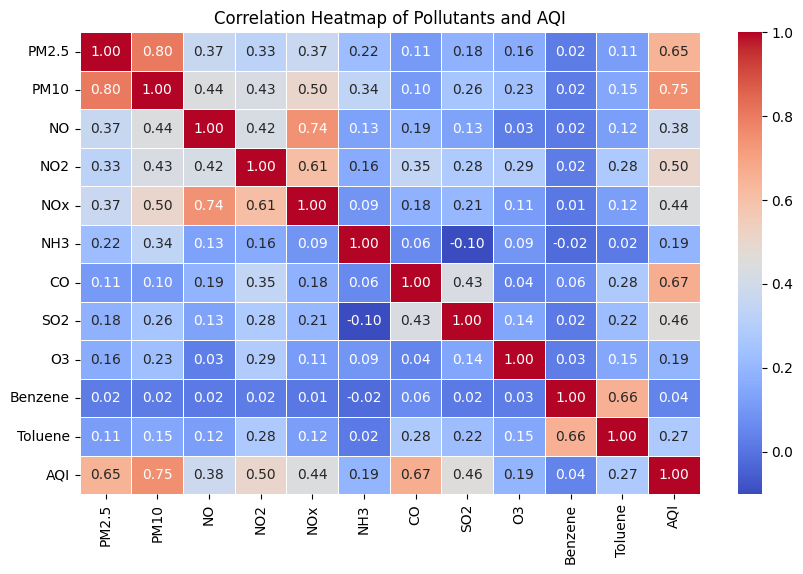

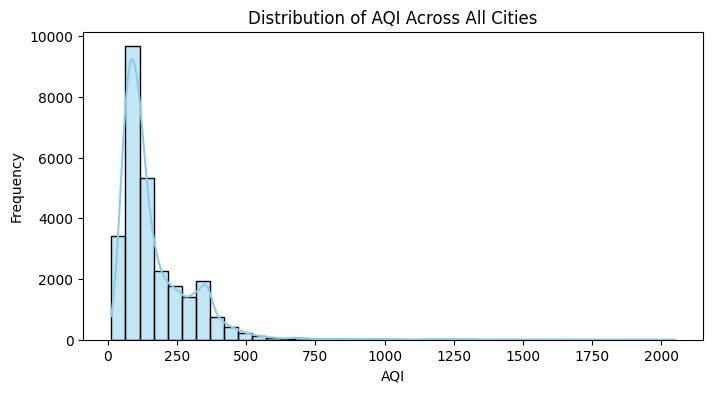

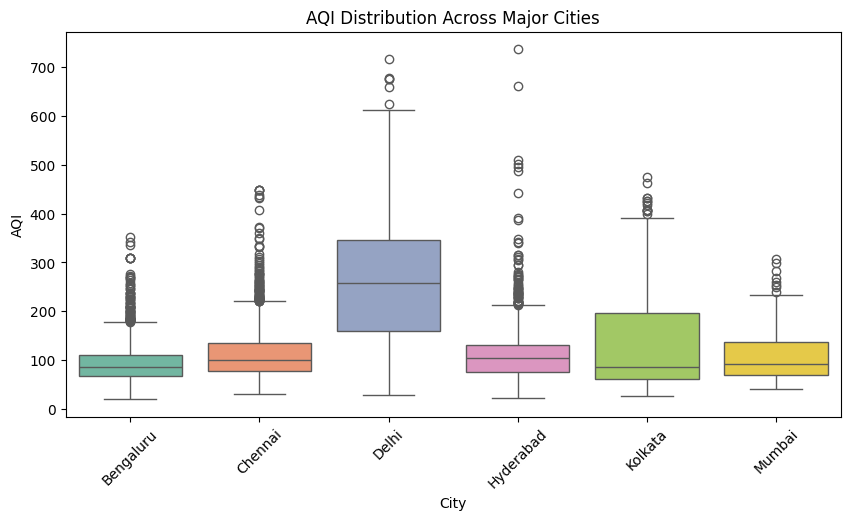

In [ ]:

# AQI Trend Over Time (for one city)
city = 'Delhi'
city_df = df[df['City'] == city]

plt.figure(figsize=(12, 5))
plt.plot(city_df['Date'], city_df['AQI'], color='teal', linewidth=2)
plt.title(f'{city} - Air Quality Index (AQI) Over Time')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.grid(alpha=0.3)
plt.show()

# Correlation Heatmap (Air Pollutants vs AQI)

cols = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'AQI']
corr = df[cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Pollutants and AQI')
plt.show()

#AQI Distribution (Histogram + KDE)
plt.figure(figsize=(8, 4))
sns.histplot(df['AQI'], bins=40, kde=True, color='skyblue')
plt.title('Distribution of AQI Across All Cities')
plt.xlabel('AQI')
plt.ylabel('Frequency')
plt.show()


#Comparison of AQI Levels Across Major Cities (Box Plot)
major_cities = ['Delhi', 'Mumbai', 'Kolkata', 'Chennai', 'Bengaluru', 'Hyderabad']
subset = df[df['City'].isin(major_cities)]

plt.figure(figsize=(10, 5))
sns.boxplot(data=subset, x='City', y='AQI', palette='Set2')
plt.title('AQI Distribution Across Major Cities')
plt.xticks(rotation=45)
plt.show()



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

ARIMA RMSE: 47.91
ARIMA MAE : 41.55


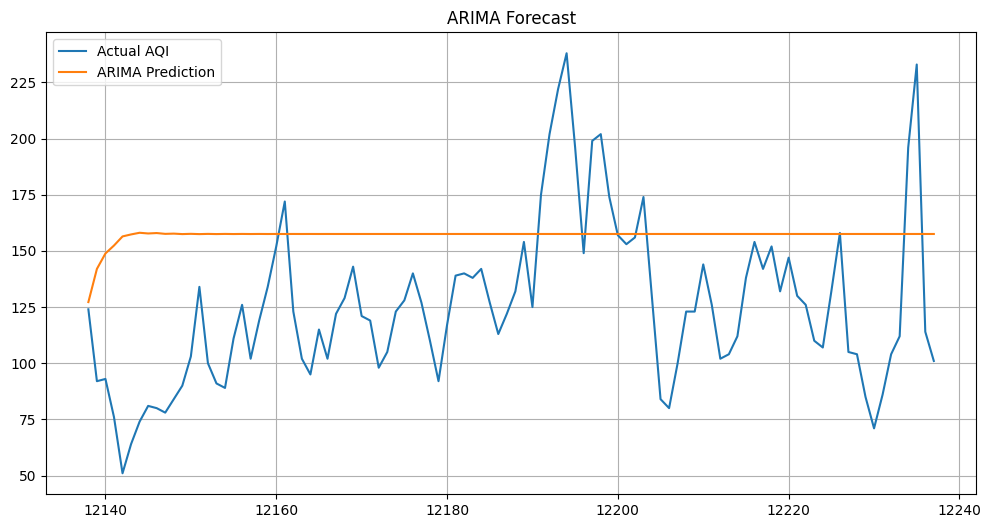

In [ ]:
# ====================================================
#       AIR QUALITY FORECASTING MODELS
#   ARIMA • SARIMA • RANDOM FOREST • XGBOOST • LSTM
# ====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator




# Train/test split
train = city_df.iloc[:-100]
test = city_df.iloc[-100:]

# =====================================================================
#                          ARIMA MODEL
# =====================================================================


# Use only numeric AQI series
train_aqi = train["AQI"]
test_aqi = test["AQI"]

# Fit ARIMA model
arima_model = ARIMA(train_aqi, order=(5,1,2))
arima_fit = arima_model.fit()

# Forecast (with integer index—this is OK)
arima_pred = arima_fit.forecast(steps=len(test_aqi))

# Convert predictions to numpy array (important)
arima_pred = np.array(arima_pred)

# Compute metrics
rmse_arima = np.sqrt(mean_squared_error(test_aqi.values, arima_pred))
mae_arima = mean_absolute_error(test_aqi.values, arima_pred)

print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE : {mae_arima:.2f}")

plt.figure(figsize=(12,6))
plt.plot(test.index, test["AQI"], label="Actual AQI")
plt.plot(test.index, arima_pred, label="ARIMA Prediction")
plt.legend()
plt.title("ARIMA Forecast")
plt.grid()
plt.show()




/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


SARIMA RMSE: 47.08
SARIMA MAE : 40.16


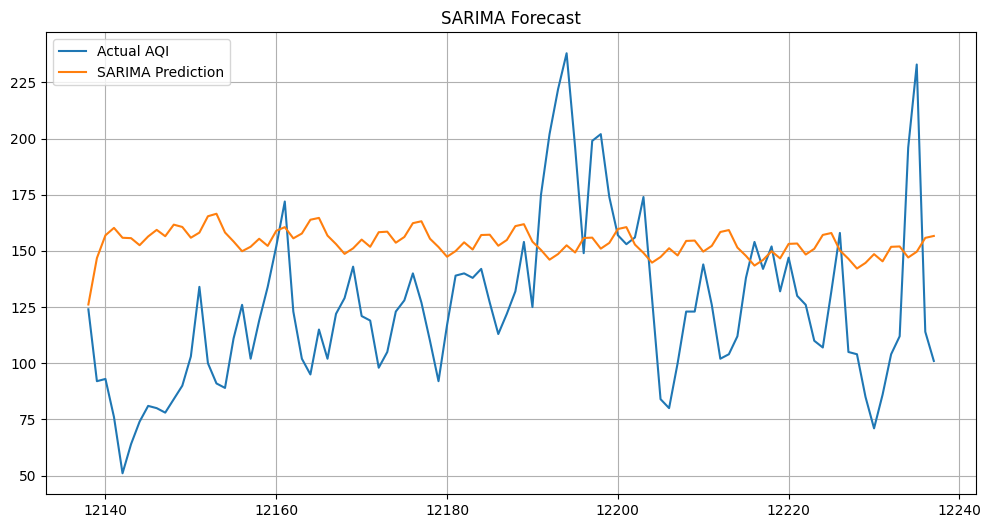

In [ ]:
# =====================================================================
#                          SARIMA MODEL
# =====================================================================

# Use only numeric AQI series
train_aqi = train["AQI"]
test_aqi = test["AQI"]

# Fit SARIMA model
sarima_model = SARIMAX(train_aqi, order=(3,1,2), seasonal_order=(2,1,1,12))
sarima_fit = sarima_model.fit()

# Forecast
sarima_pred = sarima_fit.forecast(steps=len(test_aqi))

# Convert predictions to numpy array
sarima_pred = np.array(sarima_pred)

# Compute metrics
rmse_sarima = np.sqrt(mean_squared_error(test_aqi.values, sarima_pred))
mae_sarima = mean_absolute_error(test_aqi.values, sarima_pred)

print(f"SARIMA RMSE: {rmse_sarima:.2f}")
print(f"SARIMA MAE : {mae_sarima:.2f}")

plt.figure(figsize=(12,6))
plt.plot(test.index, test["AQI"], label="Actual AQI")
plt.plot(test.index, sarima_pred, label="SARIMA Prediction")
plt.legend()
plt.title("SARIMA Forecast")
plt.grid()
plt.show()



================ RANDOM FOREST (FIXED) ================

Random Forest RMSE: 27.68
Random Forest MAE : 20.59


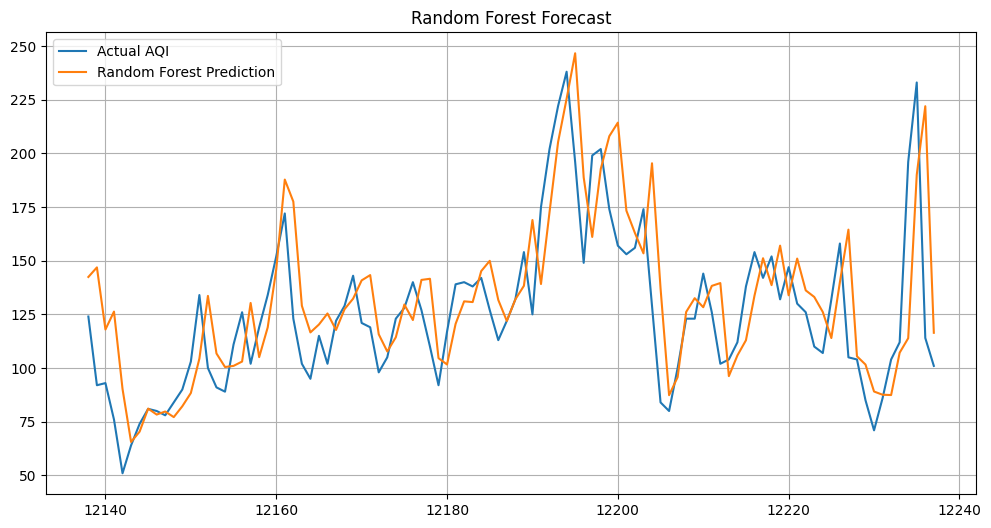

In [ ]:

# =====================================================================
#                      RANDOM FOREST REGRESSOR
# =====================================================================
print("\n================ RANDOM FOREST (FIXED) ================\n")

# Create lag features
def create_lags(df, lag=7):
    df = df.copy()
    for i in range(1, lag+1):
        df[f"lag_{i}"] = df["AQI"].shift(i)
    return df.dropna()

# Only keep AQI column before creating lags
aqi_only_df = city_df[["AQI"]]

lag_df = create_lags(aqi_only_df, lag=7)

# Input features (all lag columns)
X = lag_df.drop("AQI", axis=1)

# Target
y = lag_df["AQI"]

# Split using same 100-step rule
X_train = X.iloc[:-100]
X_test  = X.iloc[-100:]
y_train = y.iloc[:-100]
y_test  = y.iloc[-100:]

# Train model
rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)

# Predict
rf_pred = rf.predict(X_test)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_pred))
mae_rf  = mean_absolute_error(y_test, rf_pred)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAE : {mae_rf:.2f}")

plt.figure(figsize=(12,6))
plt.plot(test.index, test["AQI"], label="Actual AQI")
plt.plot(test.index, rf_pred, label="Random Forest Prediction")
plt.legend()
plt.title("Random Forest Forecast")
plt.grid()
plt.show()





================ XGBOOST ================

XGBoost RMSE: 28.27
XGBoost MAE : 20.80


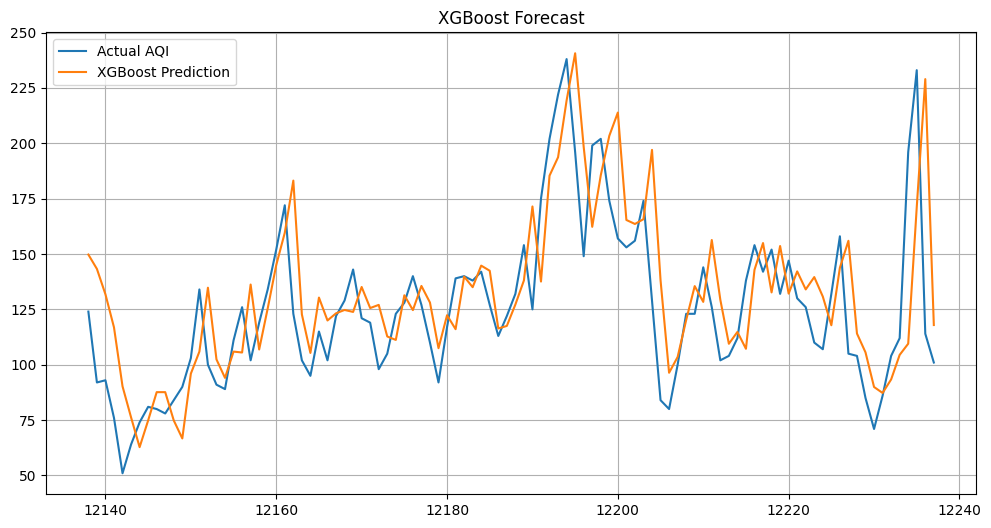

In [ ]:
# =====================================================================
#                            XGBOOST
# =====================================================================
print("\n================ XGBOOST ================\n")

xgb = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=5)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_pred))
mae_xgb = mean_absolute_error(y_test, xgb_pred)

print(f"XGBoost RMSE: {rmse_xgb:.2f}")
print(f"XGBoost MAE : {mae_xgb:.2f}")

plt.figure(figsize=(12,6))
plt.plot(test.index, test["AQI"], label="Actual AQI")
plt.plot(test.index, xgb_pred, label="XGBoost Prediction")
plt.legend()
plt.title("XGBoost Forecast")
plt.grid()
plt.show()




================ LSTM MODEL (FIXED) ================

Epoch 1/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.7908
Epoch 2/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2697
Epoch 3/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2325
Epoch 4/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2171
Epoch 5/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1993
Epoch 6/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2126
Epoch 7/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1757
Epoch 8/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1698
Epoch 9/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1830
Epoch 10/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1708
Epoch 11/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1633
Epoch 12/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1603
Epoch 13/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1739
Epoch 14/20
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1727
Ep

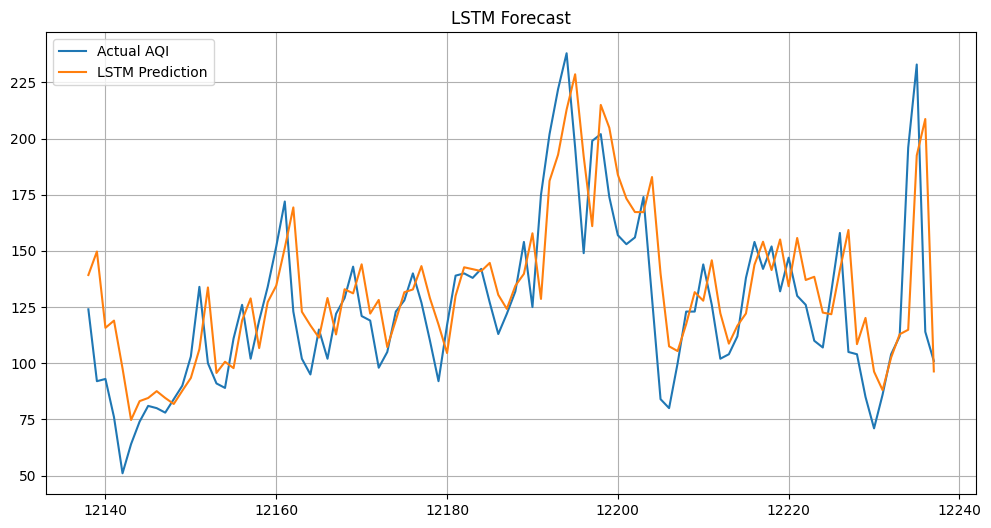

In [ ]:
print("\n================ LSTM MODEL (FIXED) ================\n")

# Use only AQI values (numeric)
aqi_series = city_df["AQI"].values.reshape(-1, 1)

# Scale only numeric AQI
scaler = StandardScaler()
scaled_aqi = scaler.fit_transform(aqi_series)

# LSTM sequence length
seq_len = 7

# Create generator
generator = TimeseriesGenerator(
    scaled_aqi, scaled_aqi,
    length=seq_len,
    batch_size=16
)

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, activation="relu", input_shape=(seq_len, 1)),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse")
lstm_model.fit(generator, epochs=20, verbose=1)

# ---- Forecast last 100 steps ---- #
lstm_preds = []
test_scaled = scaled_aqi[-(100 + seq_len):]

for i in range(100):
    sample = test_scaled[i:i+seq_len].reshape(1, seq_len, 1)
    pred = lstm_model.predict(sample, verbose=0)
    lstm_preds.append(pred[0][0])

# Inverse transform predictions
lstm_preds = scaler.inverse_transform(np.array(lstm_preds).reshape(-1, 1))

# True values (numeric only)
true_values = city_df["AQI"].iloc[-100:].values

# Metrics
rmse_lstm = np.sqrt(mean_squared_error(true_values, lstm_preds))
mae_lstm  = mean_absolute_error(true_values, lstm_preds)

print(f"LSTM RMSE : {rmse_lstm:.2f}")
print(f"LSTM MAE  : {mae_lstm:.2f}")

plt.figure(figsize=(12,6))
plt.plot(test.index, test["AQI"], label="Actual AQI")
plt.plot(test.index, lstm_preds, label="LSTM Prediction")
plt.legend()
plt.title("LSTM Forecast")
plt.grid()
plt.show()



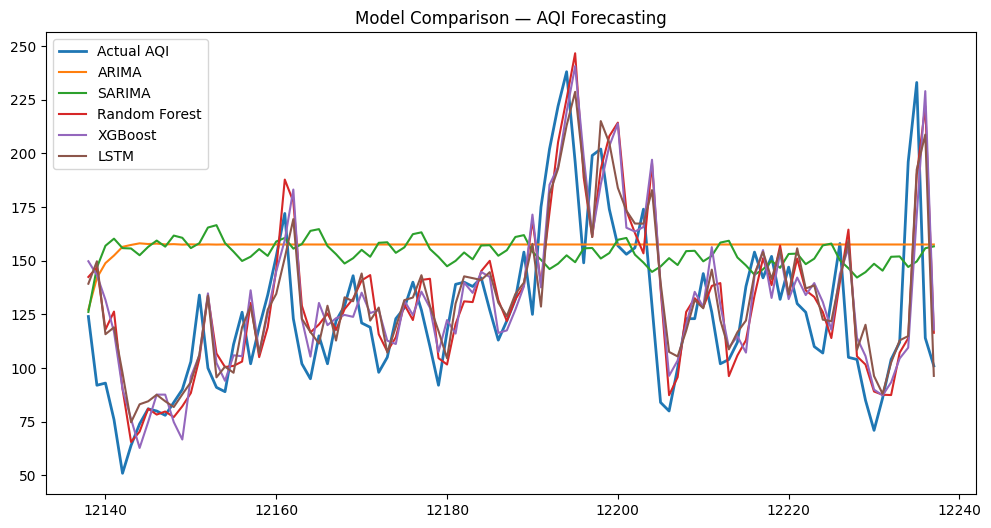

In [ ]:

# =====================================================================
#                        COMPARISON PLOT
# =====================================================================

plt.figure(figsize=(12,6))
plt.plot(test.index, test["AQI"], label="Actual AQI", linewidth=2)
plt.plot(test.index, arima_pred, label="ARIMA")
plt.plot(test.index, sarima_pred, label="SARIMA")
plt.plot(test.index, rf_pred, label="Random Forest")
plt.plot(test.index, xgb_pred, label="XGBoost")
plt.plot(test.index, lstm_preds, label="LSTM")
plt.legend()
plt.title("Model Comparison — AQI Forecasting")
plt.show()



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 20, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=3,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=2
)

grid_rf.fit(X_train, y_train)

print("Best Parameters:", grid_rf.best_params_)
print("Best RMSE:", (-grid_rf.best_score_)**0.5)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best RMSE: 53.044005701541806


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist_xgb = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "gamma": [0, 1, 5]
}

xgb = XGBRegressor(random_state=42, eval_metric='rmse')

random_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="neg_mean_squared_error"
)

random_xgb.fit(X_train, y_train)

print("Best Parameters:", random_xgb.best_params_)
print("Best RMSE:", (-random_xgb.best_score_)**0.5)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'subsample': 1.0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 1, 'colsample_bytree': 0.8}
Best RMSE: 53.90442304724041


In [ ]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 31.9 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(
    train["AQI"],
    seasonal=False,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(auto_arima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=20408.733, Time=6.85 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20629.510, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20630.531, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20629.733, Time=1.56 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20627.532, Time=0.05 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20406.741, Time=3.16 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20484.333, Time=2.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20459.847, Time=3.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=20408.733, Time=2.42 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=20425.278, Time=1.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20411.049, Time=1.30 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=4.92 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=20404.840, Time=1.56 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=20482.368, Time=0.66 sec
 ARIMA(1,1,1)(0,0,0)[0]  

In [ ]:
auto_sarima_model = auto_arima(
    train["AQI"],
    seasonal=True,
    m=12,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

print(auto_sarima_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=20410.340, Time=16.81 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=20629.510, Time=0.15 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=20631.235, Time=1.01 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=20630.397, Time=3.96 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=20627.532, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=20408.654, Time=9.07 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=20408.733, Time=2.03 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=20409.947, Time=16.24 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=20408.743, Time=7.30 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=20411.202, Time=24.51 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=20406.710, Time=4.94 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=20406.741, Time=1.35 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=20408.404, Time=6.07 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=20408.023, Time=12.62 sec
 

In [30]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def build_lstm(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int("units", min_value=32, max_value=128, step=32),
        activation="relu",
        input_shape=(seq_len, 1)
    ))
    model.add(Dense(1))

    model.compile(
        optimizer="adam",
        loss="mse"
    )
    return model

tuner = kt.RandomSearch(
    build_lstm,
    objective="val_loss",
    max_trials=5,
    directory="lstm_tuning",
    project_name="aqi_lstm"
)

tuner.search(X_train_lstm, y_train_lstm, epochs=10, validation_split=0.2)
best_lstm = tuner.get_best_models(num_models=1)[0]
best_lstm.summary()